<a href="https://colab.research.google.com/github/5h33p/graduate_admission2/blob/main/DeepLearning_Graduate_Admission_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [ ]:
!pip install kagglehub

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer

# ETL

In [ ]:
path = kagglehub.dataset_download("mohansacharya/graduate-admissions")

# print("Path to dataset files:", path)

dfs = []

for file in os.listdir(path):
    if file.endswith(".csv"):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

dataset = pd.concat(dfs, ignore_index=True)
# dataset.head()

In [ ]:
new_columns = []

for column in dataset.columns:
  new_columns.append(column.lower().strip().replace(' ', '_').replace('.', ''))

dataset.columns = new_columns

features = dataset.drop(columns='chance_of_admit')
labels = dataset.chance_of_admit

# print(features.dtypes)
features.research = features.research.astype('bool')
num_features = features.select_dtypes(['int64', 'float64']).columns
ct = ColumnTransformer([('scaler', StandardScaler(), num_features)], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=8)
X_train_scaled = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())
X_test_scaled = pd.DataFrame(ct.fit_transform(X_test), columns=ct.get_feature_names_out())
X_train_scaled.head()

,scaler__serial_no,scaler__gre_score,scaler__toefl_score,scaler__university_rating,scaler__sop,scaler__lor,scaler__cgpa,remainder__research
0,0.490464,-0.087316,-1.071966,-0.976154,-0.920691,-1.646911,-0.472867,1.0
1,-1.436618,1.847065,1.739447,0.772181,-0.411553,1.111990,1.319399,1.0
2,-0.311261,0.879874,0.912561,0.772181,1.115860,1.111990,0.838142,1.0
3,0.666991,0.616095,0.581806,-0.101986,-0.920691,-1.646911,0.323696,1.0
4,-1.061499,0.440243,1.243315,1.646349,0.606722,1.111990,1.253018,1.0


# Creating Regressor Model

In [ ]:
model = Sequential()
input = layers.InputLayer(shape=(X_train_scaled.shape[1],))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

opt = Adam(learning_rate=0.01)
model.compile(loss='mse', metrics=['mae'], optimizer=opt)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=True)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4271 - mae: 0.5277 - val_loss: 0.0550 - val_mae: 0.1659
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0412 - mae: 0.1629 - val_loss: 0.0187 - val_mae: 0.1061
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0180 - mae: 0.1062 - val_loss: 0.0111 - val_mae: 0.0824
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - mae: 0.0763 - val_loss: 0.0065 - val_mae: 0.0625
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0509 - val_loss: 0.0052 - val_mae: 0.0561
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - mae: 0.0462 - val_loss: 0.0051 - val_mae: 0.0512
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0424 - val_loss: 0.0047 - val_mae: 0.0525
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - mae: 0.0425 - val_loss: 0.0040 - val_mae: 0.0489
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - los

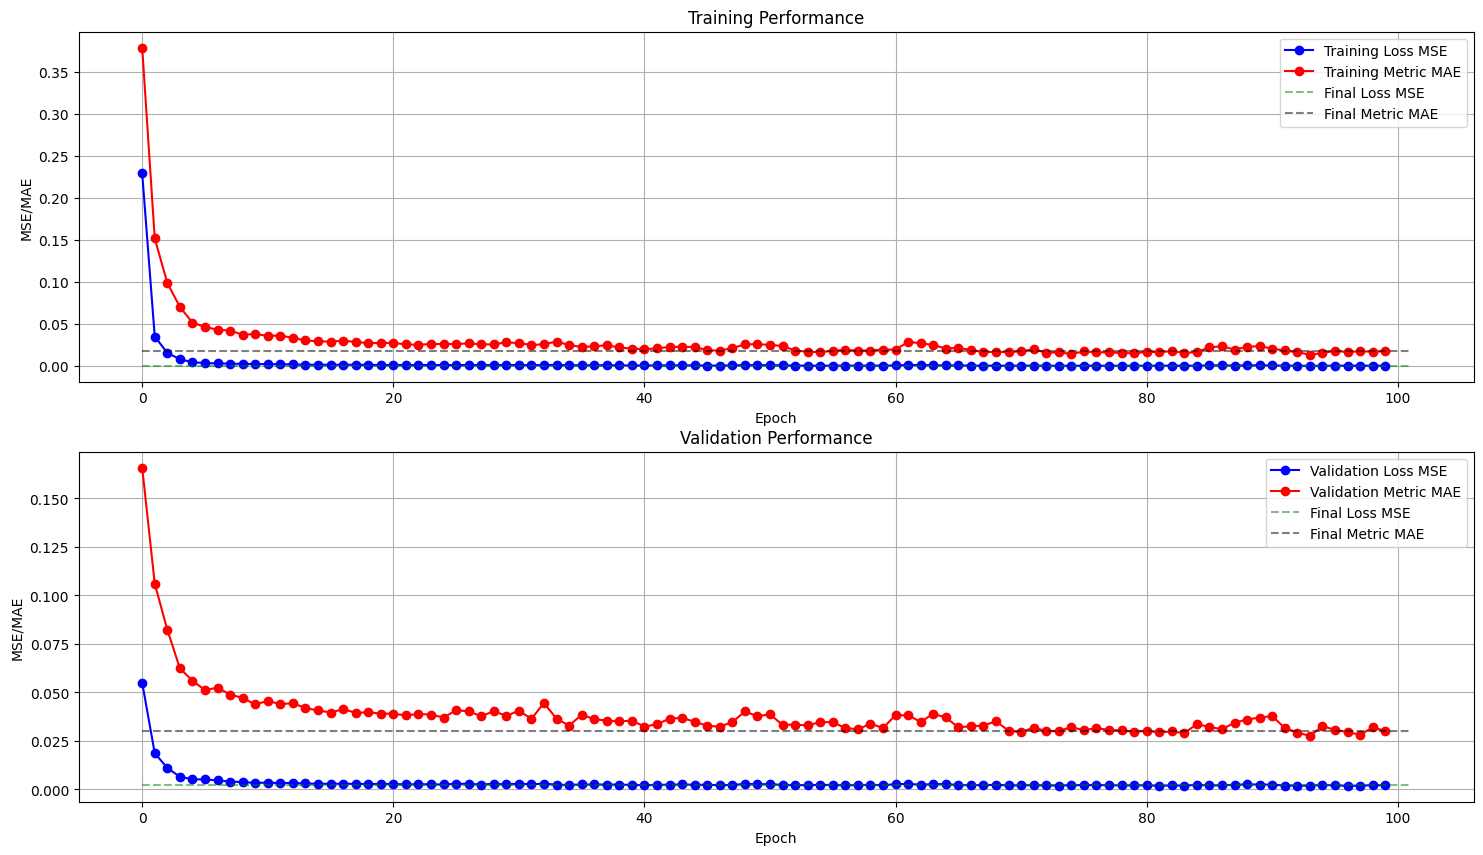

In [ ]:
mse_train = history.history['loss']
mae_train = history.history['mae']
mse_val = history.history['val_loss']
mae_val = history.history['val_mae']


X = range(1, len(mse_train) + 1)

fig, axs = plt.subplots(2, 1, figsize=(18, 10))

axs[0].plot(mse_train, '-ob', label='Training Loss MSE')
axs[0].plot(mae_train, '-or', label='Training Metric MAE')
axs[0].hlines(y=mse_train[-1], xmin=0, xmax=len(mse_train) + 1, colors='g', linestyles='--', label='Final Loss MSE', alpha=0.5)
axs[0].hlines(y=mae_train[-1], xmin=0, xmax=len(mae_train) + 1, colors='k', linestyles='--', label='Final Metric MAE', alpha=0.5)
axs[0].grid(True)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE/MAE')
axs[0].set_title('Training Performance')
axs[0].legend()

axs[1].plot(mse_val, '-ob', label='Validation Loss MSE')
axs[1].plot(mae_val, '-or', label='Validation Metric MAE')
axs[1].hlines(y=mse_val[-1], xmin=0, xmax=len(mse_val) + 1, colors='g', linestyles='--', label='Final Loss MSE', alpha=0.5)
axs[1].hlines(y=mae_val[-1], xmin=0, xmax=len(mae_val) + 1, colors='k', linestyles='--', label='Final Metric MAE', alpha=0.5)
axs[1].grid(True)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE/MAE')
axs[1].set_title('Validation Performance')
axs[1].legend()

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])